In [29]:
!pip install -q -U tensorflow-addons umap-learn

     |████████████████████████████████| 686kB 9.9MB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 1.2MB 23.8MB/s 


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

np.random.seed(2018)
np.random.RandomState(2018)
random.seed(2018)

from tensorflow.keras.preprocessing.image import load_img, img_to_array
  
from skimage.filters import try_all_threshold, threshold_otsu

import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import umap

from tensorflow.keras.applications import resnet
from tensorflow.keras import layers
from tensorflow.keras import Model

import random
import tensorflow as tf
from tqdm.notebook import tqdm

from tensorflow.keras.datasets import mnist
 
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.utils import model_to_dot

from IPython.display import SVG
from matplotlib import pyplot as plt
import math
import plotly.express as px
from sklearn.model_selection import train_test_split

np.random.seed(37)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data_base_path = "drive/MyDrive/mlexperiments/data/cedar"
img_base_path = data_base_path
forg_list = os.listdir(data_base_path + "/full_forg")
orig_list = os.listdir(data_base_path + "/full_org")
forg_list.sort()
len(forg_list)
forg_list.remove("Thumbs.db")
orig_list.remove("Thumbs.db")
forg_list[:2], orig_list[:2]

(['forgeries_10_1.png', 'forgeries_10_10.png'],
 ['original_1_11.png', 'original_6_24.png'])

 ## Structuring as Classification Task

- Each original signer is an individual class. 55 signers each with 24 examples.
- Each forgery is an individual class. 55 forgeries, each with 24 examples.
- 110 example classes total

In [4]:
img_target_size = (224, 224)

def threshold_image(img):
  thresh = threshold_otsu(img)
  return img > thresh

def get_data_np():
  orig_holder = []
  label_holder = []
  data_holder = []

  for i in tqdm(range(1,56)):
    for j in range(1,25): 
      img_path = data_base_path + "/full_org/original_" + str(i) + "_" + str(j) + ".png" 
      img_np = load_img(img_path, target_size=img_target_size )
      img_np = np.squeeze(img_to_array(img_np)) 
      img_np = resnet.preprocess_input(img_np)
      img_np = threshold_image(img_np) 
       
      data_holder.append(img_np )
      label_holder.append(i)
  for i in tqdm(range(1,56)):
    for j in range(1,25): 
      img_path = data_base_path + "/full_forg/forgeries_" + str(i) + "_" + str(j) + ".png" 
      img_np = load_img(img_path, target_size=img_target_size )
      img_np = np.squeeze(img_to_array(img_np)) 
      img_np = threshold_image(img_np)
      img_np = resnet.preprocess_input(img_np)
       
      data_holder.append(img_np )
      label_holder.append(i+55)

  return np.array(data_holder), np.array(label_holder)

X, y = get_data_np()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

threshold_otsu is expected to work correctly only for grayscale images; image shape (224, 224, 3) looks like an RGB image



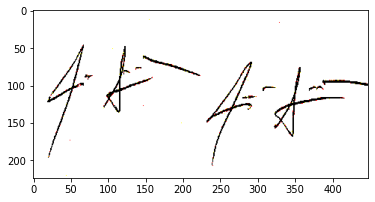

In [12]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
plt.imshow(np.concatenate((X[0],X[2]), axis=1));

In [14]:
def get_resnet(input_shape):
  base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=input_shape, include_top=False
  )

  flatten = layers.Flatten()(base_cnn.output)
  dense1 = layers.Dense(512, activation="relu")(flatten)
  dense1 = layers.BatchNormalization()(dense1)
  dense2 = layers.Dense(256, activation="relu")(dense1)
  dense2 = layers.BatchNormalization()(dense2)
  output = layers.Dense(256)(dense1)
  output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output) # L2 normalize embeddings

  embedding = Model(base_cnn.input, output, name="Embedding")

  # trainable = False
  # for layer in base_cnn.layers:
  #     if layer.name == "conv5_block1_out":
  #         trainable = True
  #     layer.trainable = trainable 
  return embedding   

In [15]:
# Compile the model
triplet_model = get_resnet(input_shape)
triplet_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),  
    loss=tfa.losses.TripletSemiHardLoss())

In [16]:
# warning .. without setting batch size to 64, training loss degrades to nan .. oops!

In [17]:
# Train the network
triplet_history = triplet_model.fit(
    X_train, y_train, 
    batch_size=64,
    validation_data=(X_test, y_test),
    epochs=30)

Epoch 1/30
33/33 [==============================] - 22s 385ms/step - loss: 0.9049 - val_loss: 0.9518
Epoch 2/30
33/33 [==============================] - 11s 343ms/step - loss: 0.7174 - val_loss: 0.9395
Epoch 3/30
33/33 [==============================] - 11s 343ms/step - loss: 0.5475 - val_loss: 0.9341
Epoch 4/30
33/33 [==============================] - 11s 343ms/step - loss: 0.4590 - val_loss: 0.9376
Epoch 5/30
33/33 [==============================] - 11s 343ms/step - loss: 0.3569 - val_loss: 0.9492
Epoch 6/30
33/33 [==============================] - 11s 343ms/step - loss: 0.2741 - val_loss: 0.9600
Epoch 7/30
33/33 [==============================] - 11s 343ms/step - loss: 0.2194 - val_loss: 0.9575
Epoch 8/30
33/33 [==============================] - 11s 343ms/step - loss: 0.1773 - val_loss: 0.9246
Epoch 9/30
33/33 [==============================] - 11s 343ms/step - loss: 0.1372 - val_loss: 0.8493
Epoch 10/30
33/33 [==============================] - 11s 343ms/step - loss: 0.0944 - val_lo

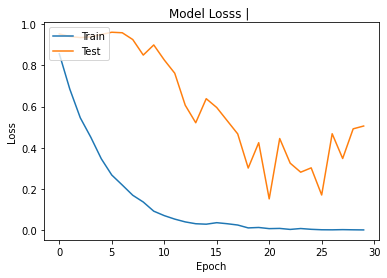

In [21]:
plot_history(triplet_history)
test_features = triplet_model(X_test)

In [20]:
def plot_features(test_features, y, title="UMAP Embedding Projection", metric="euclidean"): 
  print("Compute UMAP for vector with shape", test_features.shape, " metric:", metric)
  reducer = umap.UMAP(n_neighbors=15, n_components=2, metric=metric)
  embedding = reducer.fit_transform(test_features)

  colors = [ x for x in y] 
  acm = [x for x in colors]

  fig = px.scatter(
      x=embedding[:, 0],
      y=embedding[:, 1],
      color=acm,
      opacity=0.5,
      hover_name=acm,
      symbol=acm,
      width=1200,
      height=900,
      title=title,
  )
  fig.show()  

def plot_history(history, title=""): 
   
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Losss | ' + title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  
  plt.show()

In [22]:

plot_features(test_features, y_test, title="UMAP Embedding Projection  Triplet" , metric="cosine" )

Compute UMAP for vector with shape (528, 256)  metric: cosine
